# <center>Automatic Ticket Classification - Case Study</center>

## Problem Statement 

For a financial company, customer complaints carrys a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

In this case study, we will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as 

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


## Business Goals

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

With the help of non-negative matrix factorization (NMF), an approach under topic modelling, we will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, we will be able to identify the topics of the customer complaints. 

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others

With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree, random forest or naive bayes Classification. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## NLP Pipelines:

We need to perform the following eight major tasks to classify the tickets raised:

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

<b>Note:</b> Once we have finalised the clusters/categories for customer complaints, the next step is to create a data set that contains the complaints and labels (which you found using NMF). This labelled data set will be used for model building using supervised learning. Models like <b>Logistic Regression, Decision Tree, Random Forest, Naive Bayes Classification</b> can be used to classify the tickest into respective categories. We can then select the best performing model from these based on the evaluation metrics.

In [1]:
#!python -m spacy download en_core_web_md

## Importing required libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## 1. Data loading

### Loading data from JSON file
The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints.json','r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

### Data Understanding
We will check and undertsand the shape and size of loaded data.

In [4]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [5]:
## print dataframe info to check column details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
cols_new = [re.sub('source.','',col[1:]) for col in df]
print("New column names:\n",cols_new, "\n")

# Applying new column names
df.columns = cols_new
df.head()

New column names:
 ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'] 



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


### Cleaning Data
We will check and address null data in columns and rows

In [8]:
# Checking null count in columns
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [9]:
# printing number of blank rows in complaint column

print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  57241


In [10]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r"^\s*$",np.NaN,regex=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [11]:
# printing number of blank rows in complaint column after NAN assignment
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  0


In [12]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

print("New shape of dataframe: ")
df.shape

New shape of dataframe: 


(21072, 22)

## 2. Text preprocessing
### Prepare the text for topic modeling

Once we have removed all the blank complaints, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations we need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    # Text to lower case
    text1 = text.lower()
    
    # Removing any leading and trailing spaces
    text2 = text1.strip()
    
    # Removing text within square brackets
    text3 = re.sub(r"[\[].*?[\]]","",text2).strip()
    
    # Removing punctuations
    text4 = re.sub(r"[^\w\s]","",text3).strip()
    
    # Removing words containing numbers
    text5 = re.sub("\S*\d\S*","",text4).strip()   
    
    return text5

In [14]:
# Applying 'text_preprocess' function to remove unnecessary elements
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [16]:
df_clean = df.complaints_cleaned.to_frame()
df_clean.columns = ["complaints"]
df_clean.head()

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [17]:
#!pip install swifter

In [18]:
import swifter

In [19]:
#Write your function to Lemmatize the texts
stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    # Using nltk pos tagger which may not capture the context like Spacy's POS tagger. However, it should be good enough for use here.
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_text = ' '.join(proc_token)
    return lemmatized_text

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_what_happened","complaints_cleaned"]]
#df_clean.columns = ["raw_complaints","cleaned_complaints"]

# Apply lemmatization and store the output in a separate column
df_clean["lemmatized_complaints"] = df_clean["complaints_cleaned"].swifter.apply(lemmatizer)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [21]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [22]:
#Write your function to extract the POS tags 
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

pos_tags = []  # List to store POS tags of each lemmatized complaint
nouns = []     # List to store only the nouns from the complaint

def pos_tag(text):
    # write your code here
    for complaint in tqdm(text):
        pos = ''
        noun = ''
        proc_complaint = nlp(complaint)
        for tok in proc_complaint:
            pos += tok.pos_ + ' '
            if tok.pos_ in str(('NOUN', 'PROPN')) :
                noun += (tok.lemma_.lower()) + ' '
        pos_tags.append(pos.strip())
        nouns.append(noun.strip())



In [23]:
# Extracting POS tags
pos_tag(df_clean.lemmatized_complaints)

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [13:06<00:00, 26.79it/s]


In [24]:
# Validating POS tag for particular row
print(pos_tags[100])
print(nouns[100])

NOUN VERB VERB NOUN NOUN NOUN NOUN PROPN PROPN AUX INTJ VERB NOUN PROPN PROPN VERB ADV VERB NOUN VERB NOUN NOUN PROPN PROPN PROPN PROPN PROPN VERB NOUN NOUN SCONJ PROPN PROPN VERB ADV VERB VERB ADV NOUN NOUN PROPN X PROPN VERB NOUN NOUN SCONJ X PROPN VERB NOUN NOUN PROPN NOUN NOUN NOUN VERB NOUN NOUN ADP NOUN PROPN X PROPN VERB DET NOUN VERB NOUN NOUN ADJ NOUN NOUN NOUN NOUN VERB NOUN NOUN VERB VERB VERB PROPN PROPN PROPN ADV VERB NOUN NOUN NOUN VERB ADJ NOUN ADV ADJ NOUN PROPN PROPN VERB VERB NOUN VERB VERB VERB VERB NOUN NOUN ADV NOUN VERB NOUN PROPN PROPN ADJ ADJ VERB PROPN PROPN NOUN NOUN NOUN VERB VERB VERB ADJ NOUN PROPN PROPN AUX VERB NOUN NOUN AUX VERB ADV NOUN NOUN AUX VERB ADJ NOUN NOUN NOUN NOUN VERB VERB NOUN VERB NOUN VERB NOUN NOUN ADV VERB NOUN VERB NOUN
supervisor complaint regard case managment xxxx xxxx attention mr xxxx representative follow call mr xxxx xxxx xxxx xxxx voice mail xxxx xxxx noon xxxx xxxx xxxx voice mail xxxx voice message return call voice message re

In [25]:
# this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaints_nouns_only'] = pd.Series(nouns, index=df_clean.index)

# Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

In [26]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,xxxx card agent anniversary date agent informa...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOU...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,VERB NOUN ADJ PROPN NOUN VERB ADP NOUN VERB AD...,book xxxx ticket offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,son check deposit chase account fund clear cha...


## 3. Exploratory data analysis (EDA)

### Exploratory data analysis to get familiar with the data.

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [27]:
df_clean.complaint_what_happened.str.len().sort_values(ascending=False)

436      31611
11241    31385
14251    29948
2308     29239
1130     25757
         ...  
16450       21
8825        21
1619        20
5799        19
8697        19
Name: complaint_what_happened, Length: 21072, dtype: int64

Text(0.5, 0, 'Character length ranges')

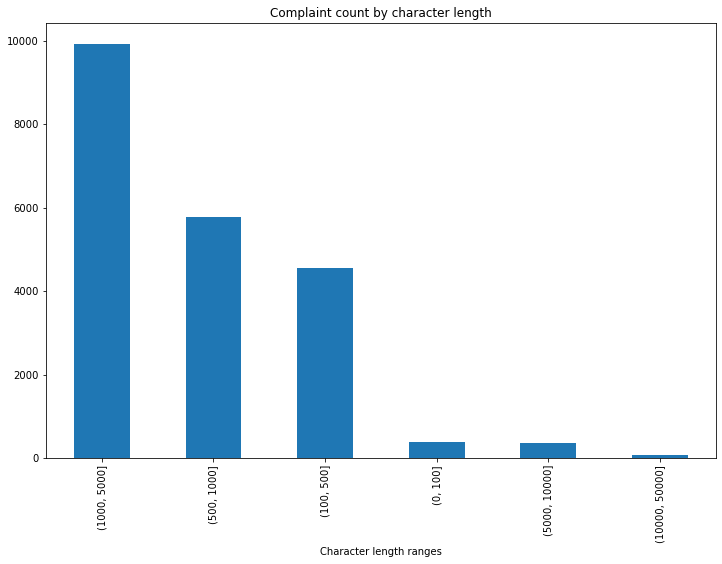

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean.complaint_what_happened.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

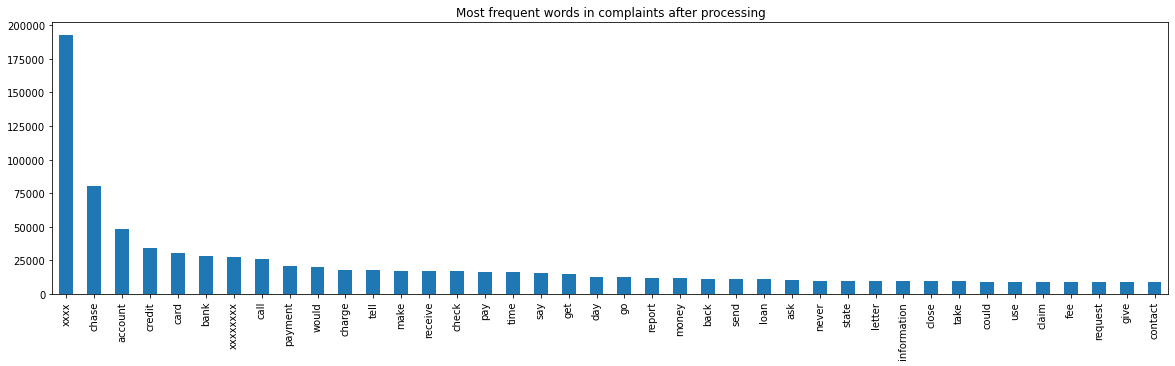

In [29]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[] # List to extract most frequent words

for complaint in df_clean.lemmatized_complaints:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [30]:
#!pip install wordcloud

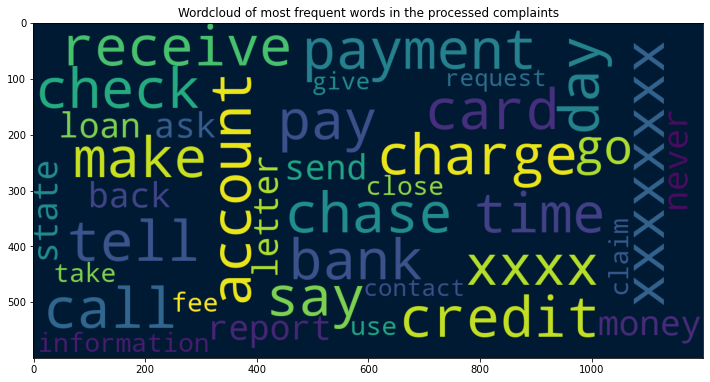

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis', max_words = 50, contour_width = 3, max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent words in the processed complaints")
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
from nltk.util import ngrams 
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

### Unigrams

In [34]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word') 
word_vect = vectorizer.fit_transform(df_clean['complaints_nouns_only']) 
freqs = sum(word_vect).toarray()[0]

unigram_df = pd.DataFrame(freqs, index=vectorizer.get_feature_names(), columns=['frequency'])
unigram_df.sort_values(by="frequency", ascending = False).head(30)

,frequency
xxxx,154667
chase,78800
account,46689
credit,33964
card,30415
bank,28601
xxxxxxxx,27905
payment,21161
call,18453
time,16048


In [35]:
#Print the top 10 words in the unigram frequency
print("Top 10 words in the unigram by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(10)

Top 10 words in the unigram by frequency:


,frequency
xxxx,154667
chase,78800
account,46689
credit,33964
card,30415
bank,28601
xxxxxxxx,27905
payment,21161
call,18453
time,16048


<Figure size 1440x360 with 0 Axes>

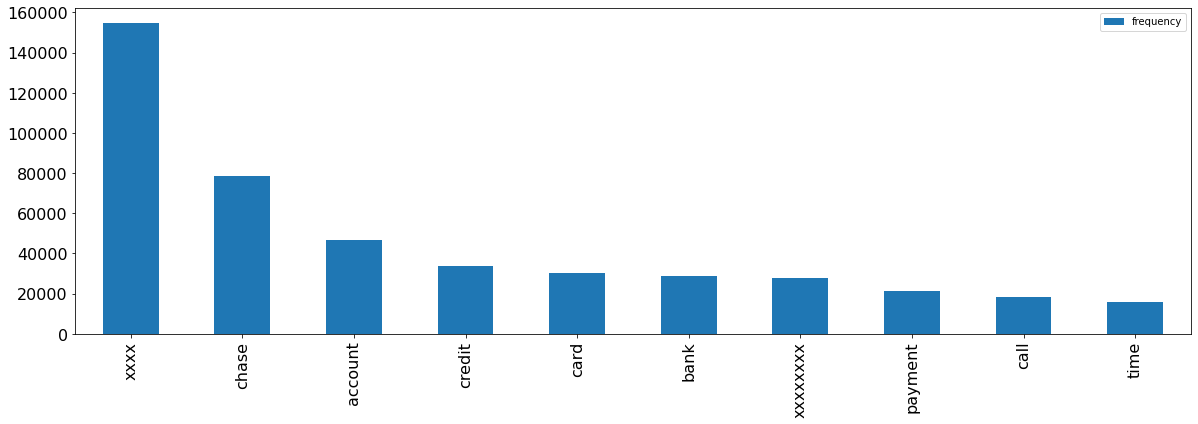

In [36]:
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### Bigrams

In [37]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), analyzer='word') 
word_vector_bigram = vectorizer_bigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_bigram = sum(word_vector_bigram).toarray()[0]

bigram_df = pd.DataFrame(freqs_bigram, index=vectorizer_bigram.get_feature_names(), columns=['frequency'])
print(bigram_df.sort_values(by="frequency", ascending = False).head(30))

                   frequency
xxxx xxxx              67013
chase bank             12897
credit card            12840
xxxx chase              5473
call chase              4308
credit report           3993
xxxxxxxx xxxx           3638
check account           3551
chase xxxx              3442
chase credit            3384
xxxx xxxxxxxx           3187
account chase           3135
customer service        3080
jp morgan               2764
account xxxx            2634
xxxx account            2623
xxxxxxxx xxxxxxxx       2596
bank account            2512
morgan chase            2475
chase account           2471
xxxx credit             2369
contact chase           1888
bank xxxx               1886
debit card              1881
number xxxx             1849
call xxxx               1779
xxxxxxxx chase          1760
credit score            1713
phone call              1704
chase card              1650


Top 10 bigrams by frequency:
               frequency
xxxx xxxx          67013
chase bank         12897
credit card        12840
xxxx chase          5473
call chase          4308
credit report       3993
xxxxxxxx xxxx       3638
check account       3551
chase xxxx          3442
chase credit        3384


<Figure size 1440x360 with 0 Axes>

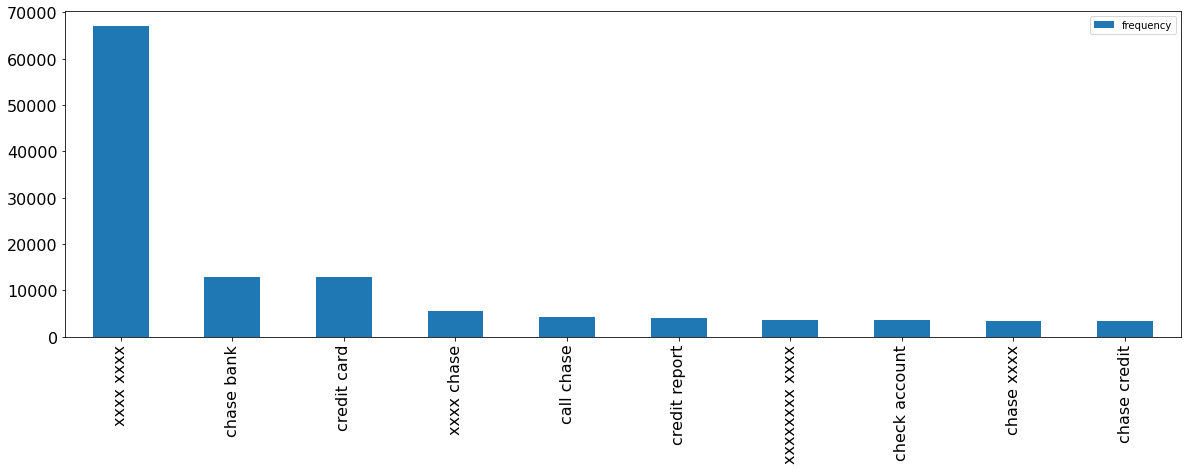

In [38]:
#Print the top 10 words in the bigram frequency
print("Top 10 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(10))

plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### Trigrams

In [39]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer_trigram = CountVectorizer(ngram_range=(3,3), analyzer='word') 
word_vector_trigram = vectorizer_trigram.fit_transform(df_clean['complaints_nouns_only']) 
freqs_trigram = sum(word_vector_trigram).toarray()[0]

trigram_df = pd.DataFrame(freqs_trigram, index=vectorizer_trigram.get_feature_names(), columns=['frequency'])
print(trigram_df.sort_values(by="frequency", ascending = False).head(30))

                            frequency
xxxx xxxx xxxx                  32438
chase credit card                2351
xxxx xxxx chase                  2348
jp morgan chase                  2302
xxxxxxxx xxxx xxxx               1834
xxxx xxxx xxxxxxxx               1449
chase xxxx xxxx                  1340
chase bank xxxx                  1142
xxxx credit card                 1101
xxxx xxxxxxxx xxxx               1087
credit card account              1031
account xxxx xxxx                 978
credit card company               970
xxxx xxxx account                 948
xxxx chase bank                   913
bank xxxx xxxx                    884
credit card chase                 845
xxxx xxxx credit                  792
account chase bank                765
name xxxx xxxx                    703
chase bank account                694
morgan chase bank                 679
xxxxxxxx xxxxxxxx xxxxxxxx        672
call xxxx xxxx                    659
chase customer service            622
credit card 

Top 10 trigrams by frequency:
                    frequency
xxxx xxxx xxxx          32438
chase credit card        2351
xxxx xxxx chase          2348
jp morgan chase          2302
xxxxxxxx xxxx xxxx       1834
xxxx xxxx xxxxxxxx       1449
chase xxxx xxxx          1340
chase bank xxxx          1142
xxxx credit card         1101
xxxx xxxxxxxx xxxx       1087


<Figure size 1440x360 with 0 Axes>

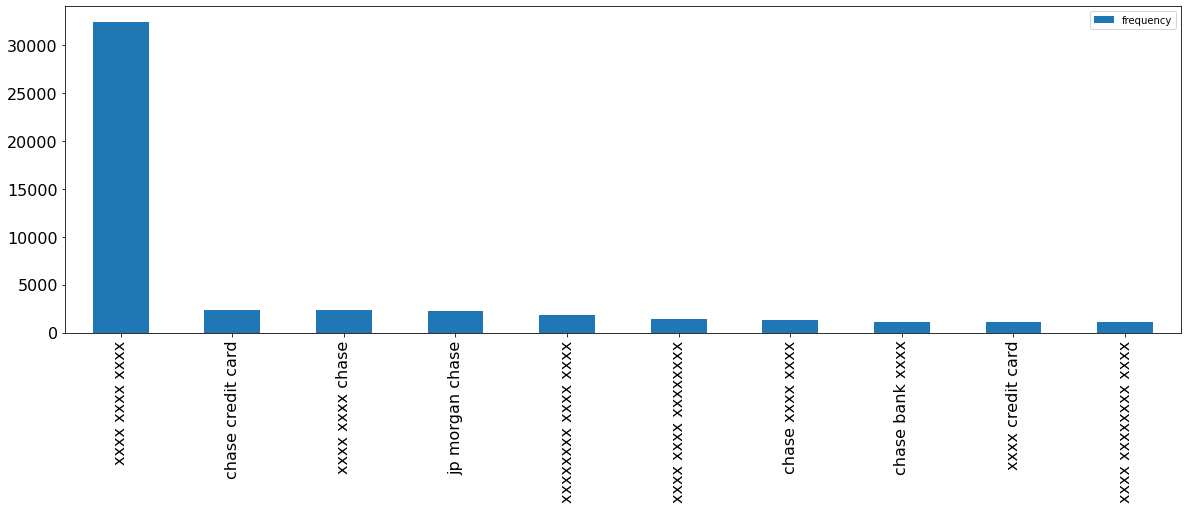

In [40]:
#Print the top 10 words in the trigram frequency
print("Top 10 trigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(10))

plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:10].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as masked texts will be of no use for our analysis.

In [41]:
# Replacing masked text ("xxxx")
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxxx','')
df_clean['lemmatized_complaints'] = df_clean['lemmatized_complaints'].str.replace('xxxx','')
df_clean['complaints_nouns_only'] = df_clean['complaints_nouns_only'].str.replace('xxxx','')

In [42]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service c...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,card agent anniversary date agent information...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOU...,chase card report application submit identity ...,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOU...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN ADJ PROPN NOUN VERB ADP NOUN VERB AD...,book ticket offer ticket reward card informat...,VERB NOUN ADJ PROPN NOUN VERB ADP NOUN VERB AD...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,son check deposit chase account fund clear cha...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...


## 4. Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [43]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    max_features=5000, # Keeping max_features to 5000 to keep within memory limits.
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [44]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaints_nouns_only'])
features = tfidf_vectorizer.get_feature_names()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

,ability,abuse,acceptance,access,access account,access bank,access chase,access credit,access fund,access information,...,year mortgage,year pay,year payment,year time,year work,year year,yesterday,york,yr,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
tfidf_df.shape

(21072, 5000)

In [46]:
len(tfidf_vectorizer.get_feature_names())

5000

## 5. Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [47]:
from sklearn.decomposition import NMF

### Manual Topic Modeling
We need to take the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

### Starting with 15 topics

In [48]:
#Load your nmf_model with the n_components i.e 15
num_topics = 15 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [49]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [50]:
#Print the Top 15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,account chase,chase account,account account,chase,check account,bank account,reason,access,transfer,balance,branch,card account,money account,business
Topic 2,card,credit,credit card,chase credit,chase credit card,chase,card chase,chase card,score,card account,card credit,credit card chase,limit,use,credit score
Topic 3,mortgage,home,property,chase,chase mortgage,modification,foreclosure,house,year,sale,mortgage payment,escrow,tax,insurance,bankruptcy
Topic 4,inquiry,inquiry credit,inquiry credit report,credit report,credit,jpmcb,credit inquiry,card inquiry,report inquiry,jpmcb card,inquiry inquiry,report,inquiry chase,credit report inquiry,application
Topic 5,payment,payment payment,month,payment chase,pay,chase payment,amount,chase,day,payment credit,time,payment account,payment month,auto,payment time
Topic 6,charge,dispute,merchant,dispute charge,company,chase,charge chase,charge account,purchase,amount,refund,charge charge,chase charge,item,charge credit
Topic 7,fee,overdraft,overdraft fee,charge,charge fee,fee charge,transaction,charge overdraft,fee account,charge overdraft fee,pay,fee fee,fee chase,time,year
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,bank jp,bank jp morgan,foreclosure,request
Topic 9,bank,chase bank,chase,bank account,money,bank chase,chase bank account,account chase bank,bank bank,bank credit,bank chase bank,call chase bank,wire,complaint,chase bank credit
Topic 10,call,chase,phone,number,letter,email,information,time,customer,service,state,request,day,contact,address


### Trying with 10 topics

In [51]:
#Load your nmf_model with the n_components 

# Trying 10 topics
num_topics = 10 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,chase,call,claim,number,transaction,phone,email,day,fraud,information,time,money,letter,customer,state
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card chase,card account,chase card,score,account,limit,balance,credit card account,year
Topic 3,loan,mortgage,modification,chase,home,property,year,rate,foreclosure,loan modification,house,sale,refinance,document,chase mortgage
Topic 4,report,inquiry,credit,credit report,inquiry credit,inquiry credit report,bureau,report credit,credit bureau,jpmcb,information,reporting,debt,company,identity
Topic 5,payment,payment payment,month,pay,balance,payment chase,chase,statement,chase payment,interest,amount,auto,time,day,bill
Topic 6,charge,dispute,merchant,dispute charge,chase,company,charge chase,purchase,charge account,amount,refund,charge charge,item,fraud,chase charge
Topic 7,fee,overdraft,balance,charge,overdraft fee,interest,charge fee,transaction,pay,fee charge,transfer,rate,charge overdraft,fee account,charge overdraft fee
Topic 8,morgan,jp,jp morgan,morgan chase,jp morgan chase,morgan chase bank,chase,complaint,account jp,account jp morgan,morgan chase credit,foreclosure,bank jp,bank jp morgan,request
Topic 9,bank,chase bank,chase,money,bank account,bank chase,chase bank account,account chase bank,bank bank,bank money,cash,bank chase bank,bank credit,call chase bank,wire
Topic 10,account,check,deposit,fund,check account,chase,money,account chase,branch,chase account,account account,day,business,reason,access


### Trying with 5 topics

In [52]:
#Load your nmf_model with the n_components 

# Trying 5 topics
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,deposit,chase bank,fund,transaction,branch,call,day,check account,claim,account chase
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,call,merchant,company,service,time,card chase
Topic 3,loan,mortgage,chase,modification,home,property,morgan,jp,jp morgan,document,foreclosure,year,letter,morgan chase,jp morgan chase
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,bureau,account,report credit,credit bureau,debt,score,jpmcb,reporting,information
Topic 5,payment,balance,fee,interest,month,pay,payment payment,statement,payment chase,amount,chase payment,chase,bill,time,account


In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [54]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping_num.get(x.idxmax()) if x.idxmax() in topic_mapping_num.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.023112,0.005104,0.019724,0.012145,0.003998,0
1,0.006182,0.014788,0.004783,0.002566,0.000707,1
2,0.000000,0.022435,0.002206,0.038814,0.000000,3
3,0.019068,0.021018,0.017115,0.062396,0.000000,3
4,0.062723,0.000000,0.001408,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.105327,0.000000,3
6,0.051567,0.003615,0.010213,0.000000,0.010765,0
7,0.001872,0.005854,0.041531,0.000240,0.049191,4
8,0.040059,0.026694,0.020860,0.003407,0.001497,0
9,0.000000,0.050606,0.000000,0.072724,0.000000,3


In [55]:
# Checking the frequency of each identified topic
W['max_topic'].value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: max_topic, dtype: int64

In [56]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =W['max_topic'].apply(lambda x:int(x))

In [57]:
df_clean.tail()

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB AD...,chase card customer decade solicitation credit...,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB AD...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN VERB PROPN PROPN PROPN NOUN ...,wednesday call visa credit card provider as...,PROPN PROPN PROPN VERB PROPN PROPN PROPN NOUN ...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ PROPN VERB VERB ADJ NOUN VERB NOUN VERB AD...,risk consumer chase bank app chase year trust...,ADJ PROPN VERB VERB ADJ NOUN VERB NOUN VERB AD...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,PROPN NOUN PROPN PRON VERB NOUN NOUN NOUN NOUN...,flawless credit yrs chase credit card chase fr...,PROPN NOUN PROPN PRON VERB NOUN NOUN NOUN NOUN...,4
21071,Roughly 10+ years ago I closed out my accounts...,roughly years ago i closed out my accounts wi...,roughly year ago close account jp morgan chase...,ADV NOUN ADV ADJ NOUN PROPN PROPN PROPN PROPN ...,year account jp morgan chase bank order line ...,ADV NOUN ADV ADJ NOUN PROPN PROPN PROPN PROPN ...,4


In [58]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   complaints_cleaned       21072 non-null  object
 2   lemmatized_complaints    21072 non-null  object
 3   complaint_POS_removed    21072 non-null  object
 4   complaints_nouns_only    21072 non-null  object
 5   Complaint_clean          21072 non-null  object
 6   Topic                    21072 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [59]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample = df_clean.groupby('Topic').head(5)

#df_clean_sample.sort_values('Topic')
df_clean_sample.sort_values(by='Topic')

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service c...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,0
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,son check deposit chase account fund clear cha...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,0
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and,mishandle account chase auto,PROPN PROPN PROPN NOUN NOUN,mishandle account chase auto,PROPN PROPN PROPN NOUN NOUN,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,VERB PROPN PROPN PROPN NOUN NOUN NOUN NOUN PRO...,jp morgan chase restrict account debit card tu...,VERB PROPN PROPN PROPN NOUN NOUN NOUN NOUN PRO...,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer u...,make payment online retailer use chase quick ...,PROPN VERB NOUN ADJ NOUN NOUN NOUN ADJ NOUN PR...,payment retailer use chase pay chase website...,PROPN VERB NOUN ADJ NOUN NOUN NOUN ADJ NOUN PR...,0
22,My roommate was stealing my Chase debit card a...,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,VERB PROPN PROPN NOUN NOUN NOUN NOUN VERB VERB...,steal chase debit card driver license money ac...,VERB PROPN PROPN NOUN NOUN NOUN NOUN VERB VERB...,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i am a senior citizen that has been scammed by...,senior citizen scammed several company pay t...,ADJ NOUN VERB ADJ NOUN ADJ PROPN VERB NOUN NOU...,citizen company time share company credit car...,ADJ NOUN VERB ADJ NOUN ADJ PROPN VERB NOUN NOU...,1
16,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chairs and was ne...,sofa love seat table chair never deliver deb...,NOUN PROPN PROPN VERB NOUN NOUN NOUN ADV VERB ...,sofa seat table chair debit card charge bank...,NOUN PROPN PROPN VERB NOUN NOUN NOUN ADV VERB ...,1
14,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase amazon card decline cater order place br...,PROPN PROPN PROPN PROPN NOUN PROPN PROPN NOUN ...,chase amazon card decline cater order place br...,PROPN PROPN PROPN PROPN NOUN PROPN PROPN NOUN ...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,card agent anniversary date agent information...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,1


In [60]:
# Checking whether each complaint has an assigned topic or not; and whether the count for each topic matches that from our Document-Topic matrix
df_clean.Topic.value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: Topic, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Mortgage/Loan
* Theft/Dispute Reporting
* Others

In [61]:
#Create the dictionary of Topic names and Topics

Topic_names =   {
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
                }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [62]:
df_clean.Topic.value_counts()

Credit Card/Prepaid Card    6160
Bank account services       6026
Mortgages/loans             3895
Others                      2534
Theft/Dispute reporting     2457
Name: Topic, dtype: int64

## 6. Model building using supervised learning

### Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [63]:
#Create the dictionary again of Topic names and Topics

topic_labels = {
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)

In [64]:
df_clean

,complaint_what_happened,complaints_cleaned,lemmatized_complaints,complaint_POS_removed,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it ...,good morning name appreciate could help put ...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,morning name chase bank cardmember service c...,ADJ NOUN NOUN PROPN PROPN VERB AUX VERB VERB V...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the a...,upgraded card tell agent upgrade anniversary...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,card agent anniversary date agent information...,VERB ADJ PROPN PROPN VERB NOUN VERB NOUN NOUN ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOU...,chase card report application submit identity ...,PROPN NOUN NOUN ADV ADJ NOUN NOUN NOUN ADP NOU...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came a...,try book ticket come across offer apply towa...,VERB NOUN ADJ PROPN NOUN VERB ADP NOUN VERB AD...,book ticket offer ticket reward card informat...,VERB NOUN ADJ PROPN NOUN VERB ADP NOUN VERB AD...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,son check deposit chase account fund clear cha...,ADJ PROPN VERB NOUN NOUN PROPN PROPN PROPN PRO...,0
...,...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB AD...,chase card customer decade solicitation credit...,PROPN NOUN NOUN ADJ NOUN VERB ADJ NOUN VERB AD...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit c...,wednesday call chas visa credit card provid...,PROPN PROPN PROPN VERB PROPN PROPN PROPN NOUN ...,wednesday call visa credit card provider as...,PROPN PROPN PROPN VERB PROPN PROPN PROPN NOUN ...,1
21069,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not unders...,familiar pay understand great risk provide co...,ADJ PROPN VERB VERB ADJ NOUN VERB NOUN VERB AD...,risk consumer chase bank app chase year trust...,ADJ PROPN VERB VERB ADJ NOUN VERB NOUN VERB AD...,0
21070,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,PROPN NOUN PROPN PRON VERB NOUN NOUN NOUN NOUN...,flawless credit yrs chase credit card chase fr...,PROPN NOUN PROPN PRON VERB NOUN NOUN NOUN NOUN...,4


In [65]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [66]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [67]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0


In [68]:
training_data.Topic.value_counts()

1    6160
0    6026
2    3895
4    2534
3    2457
Name: Topic, dtype: int64

In [69]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data.complaint_what_happened)

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [70]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

In [71]:
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,...,xxxx xxxx credit,xxxx xxxx received,xxxx xxxx told,xxxx xxxx xx,xxxx xxxx xxxx,xxxx years,year,years,years ago,yes
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.160604,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.035616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.068232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [72]:
word_vect_df.shape

(21072, 883)

In [73]:
# Displaying feature names
features = vectorizer.get_feature_names()
print(features)

['00', '00 account', '00 chase', '00 xx', '00 xx xx', '00 xxxx', '00 xxxx xxxx', '10', '10 days', '100', '100 00', '1000', '1000 00', '12', '15', '18', '19', '20', '200', '200 00', '2000', '2000 00', '2015', '2016', '2017', '2018', '2019', '2020', '24', '30', '30 days', '50', '500', '500 00', '60', '90', 'ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'account chase', 'account chase bank', 'account closed', 'account number', 'account xx', 'account xx xx', 'account xxxx', 'account xxxx xxxx', 'accounts', 'act', 'action', 'actions', 'activity', 'actually', 'add', 'added', 'addition', 'additional', 'address', 'advised', 'agencies', 'agency', 'agent', 'ago', 'agreed', 'agreement', 'alert', 'allow', 'allowed', 'amazon', 'amounts', 'annual', 'answer', 'app', 'apparently', 'appears', 'application', 'applied', 'apply', 'approval', 'approved', 'approximately', 'ask', 'asked', 'asking', 'assist', 'assistance', 'assured', 'atm', 'attached', 'attempt', 'att

In [74]:
word_vect_df["Topic"] = training_data["Topic"]

In [75]:
from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

In [76]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=40, stratify=y)

In [77]:
# Defining a function to evaluate the models
from sklearn import metrics

def evaluate_model(y_actual,y_pred):
       
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    f1_score = metrics.f1_score(y_actual,y_pred, average="weighted")
    
    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("f1 Score: ", f1_score)
    print("\nClassificationReport:")
    print(clf_report)
    
    return accuracy, f1_score

## 7. Model training and evaluation

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred=logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [79]:
# Printing accuracy and f1 score for train dataset with logistic regression

lr_train_metrics = evaluate_model(y_train.values,y_train_pred)
lr_train_accuracy, lr_train_f1_Score = lr_train_metrics[0], lr_train_metrics[1]
print("Logistic Regression Train Accuracy: ",lr_train_accuracy)
print("Logistic Regression Train F1 Score: ",lr_train_f1_Score)

Accuracy   : 0.9627309541888129

Confusion matrix:
 [[4415   65   28    5    6]
 [  47 4516   18   21   18]
 [  44   37 2814   12   14]
 [  29   45   19 1740   10]
 [  54   63   48    6 1730]]
f1 Score:  0.9626110653018912

ClassificationReport:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4519
           1       0.96      0.98      0.97      4620
           2       0.96      0.96      0.96      2921
           3       0.98      0.94      0.96      1843
           4       0.97      0.91      0.94      1901

    accuracy                           0.96     15804
   macro avg       0.97      0.95      0.96     15804
weighted avg       0.96      0.96      0.96     15804

Logistic Regression Train Accuracy:  0.9627309541888129
Logistic Regression Train F1 Score:  0.9626110653018912


In [80]:
# Printing accuracy and f1 score for test dataset with logistic regression

lr_test_metrics = evaluate_model(y_test.values,y_pred)
lr_test_accuracy, lr_test_f1_Score = lr_test_metrics[0], lr_test_metrics[1]
print("Logistic Regression Test Accuracy: ",lr_test_accuracy)
print("Logistic Regression Test F1 Score: ",lr_test_f1_Score)

Accuracy   : 0.9345102505694761

Confusion matrix:
 [[1449   37   11    3    7]
 [  29 1485    6   12    8]
 [  37   33  888    5   11]
 [  12   19   17  557    9]
 [  38   22   25    4  544]]
f1 Score:  0.9341732980603865

ClassificationReport:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1507
           1       0.93      0.96      0.95      1540
           2       0.94      0.91      0.92       974
           3       0.96      0.91      0.93       614
           4       0.94      0.86      0.90       633

    accuracy                           0.93      5268
   macro avg       0.94      0.92      0.93      5268
weighted avg       0.93      0.93      0.93      5268

Logistic Regression Test Accuracy:  0.9345102505694761
Logistic Regression Test F1 Score:  0.9341732980603865


### Decision Tree - Classification

In [81]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
tree = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=40)

In [82]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

In [83]:
# Printing accuracy and f1 score for train dataset with Decision Tree

dt_train_metrics = evaluate_model(y_train.values,y_train_pred_tree)
dt_train_accuracy, dt_train_f1_Score = dt_train_metrics[0], dt_train_metrics[1]
print("Decision Tree Train Accuracy: ",dt_train_accuracy)
print("Decision Tree Train F1 Score: ",dt_train_f1_Score)

Accuracy   : 0.8202353834472286

Confusion matrix:
 [[3600  323  373  115  108]
 [ 200 3718  299  229  174]
 [ 148   96 2453  107  117]
 [  26   90  114 1564   49]
 [  56   40  129   48 1628]]
f1 Score:  0.8214707438777529

ClassificationReport:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      4519
           1       0.87      0.80      0.84      4620
           2       0.73      0.84      0.78      2921
           3       0.76      0.85      0.80      1843
           4       0.78      0.86      0.82      1901

    accuracy                           0.82     15804
   macro avg       0.81      0.83      0.82     15804
weighted avg       0.83      0.82      0.82     15804

Decision Tree Train Accuracy:  0.8202353834472286
Decision Tree Train F1 Score:  0.8214707438777529


In [84]:
# Printing accuracy and f1 score for test dataset with Decision Tree

dt_test_metrics = evaluate_model(y_test.values,y_test_pred_tree)
dt_test_accuracy, dt_test_f1_Score = dt_test_metrics[0], dt_test_metrics[1]
print("Decision Tree Test Accuracy: ",dt_test_accuracy)
print("Decision Tree Test F1 Score: ",dt_test_f1_Score)

Accuracy   : 0.770501138952164

Confusion matrix:
 [[1115  146  150   43   53]
 [  75 1199  103  102   61]
 [  58   45  787   32   52]
 [  28   48   44  480   14]
 [  38   30   60   27  478]]
f1 Score:  0.7717677010365578

ClassificationReport:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1507
           1       0.82      0.78      0.80      1540
           2       0.69      0.81      0.74       974
           3       0.70      0.78      0.74       614
           4       0.73      0.76      0.74       633

    accuracy                           0.77      5268
   macro avg       0.76      0.77      0.76      5268
weighted avg       0.78      0.77      0.77      5268

Decision Tree Test Accuracy:  0.770501138952164
Decision Tree Test F1 Score:  0.7717677010365578


### Decision Tree- Hyperparameter Tuning

In [85]:
# Decision Tree - hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, GridSearchCV

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

dt_cv = GridSearchCV(estimator = dt, param_grid = params_dt, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

dt_cv.fit(X_train, y_train)

dt_cv_results = pd.DataFrame(dt_cv.cv_results_)
print(dt_cv.best_params_)
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 20, 'min_samples_leaf': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.020263,0.064987,0.054674,0.004860,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.713698,0.702942,0.693768,...,0.700646,0.008368,14,0.721585,0.721348,0.707427,0.716760,0.717494,0.716923,0.005135
1,4.080445,0.095447,0.049029,0.007961,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.711484,0.703258,0.695033,...,0.700835,0.007078,13,0.720873,0.720873,0.707743,0.716760,0.717574,0.716765,0.004812
2,4.619962,0.347384,0.092762,0.027158,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.712433,0.699462,0.693451,...,0.700203,0.008255,15,0.720003,0.718105,0.705766,0.714862,0.716229,0.714993,0.004929
3,4.994700,0.840886,0.083826,0.059362,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.709902,0.700411,0.694717,...,0.699950,0.006558,16,0.715178,0.717947,0.701732,0.714308,0.715596,0.712952,0.005738
4,9.284326,0.675643,0.063648,0.009023,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.768428,0.774122,0.777286,...,0.771260,0.004207,7,0.833030,0.832793,0.834612,0.834058,0.831778,0.833254,0.000993
5,9.331586,0.422545,0.062479,0.009206,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.768744,0.764948,0.773489,...,0.767970,0.004456,8,0.821799,0.818635,0.821087,0.818398,0.813904,0.818764,0.002770
6,8.088177,0.396066,0.062528,0.015075,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.768428,0.765264,0.770959,...,0.766072,0.003513,9,0.804160,0.801708,0.802737,0.803290,0.796900,0.801759,0.002557
7,6.862398,0.267275,0.067341,0.012765,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.764631,0.754508,0.757672,...,0.754176,0.006722,12,0.781856,0.784782,0.781223,0.776240,0.776178,0.780056,0.003363
8,11.284401,0.108494,0.055396,0.006021,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.787093,0.788042,0.777286,...,0.778727,0.008186,3,0.893775,0.897809,0.893222,0.888871,0.894970,0.893729,0.002900
9,10.232509,0.120400,0.055974,0.003587,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.795951,0.781715,0.783613,...,0.784042,0.008307,1,0.861188,0.860713,0.857787,0.856363,0.858510,0.858912,0.001808


In [86]:
# Predicting with best parameter

dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [87]:
# Printing accuracy and f1 score for train dataset with Decision tree tuned parameter

dt_train_metrics = evaluate_model(y_train.values,y_train_pred_dt)
dt_train_accuracy, dt_train_f1_score = dt_train_metrics[0], dt_train_metrics[1]
print("Decision Tree Train Accuracy: ",dt_train_accuracy)
print("Decision Tree Train F1 Score: ",dt_train_f1_score)

Accuracy   : 0.8620602379144521

Confusion matrix:
 [[3876  184  212  110  137]
 [ 196 3919  143  223  139]
 [ 151   73 2481  100  116]
 [  26   51   54 1669   43]
 [  31   43   98   50 1679]]
f1 Score:  0.8629003063146073

ClassificationReport:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4519
           1       0.92      0.85      0.88      4620
           2       0.83      0.85      0.84      2921
           3       0.78      0.91      0.84      1843
           4       0.79      0.88      0.84      1901

    accuracy                           0.86     15804
   macro avg       0.84      0.87      0.85     15804
weighted avg       0.87      0.86      0.86     15804

Decision Tree Train Accuracy:  0.8620602379144521
Decision Tree Train F1 Score:  0.8629003063146073


In [88]:
# Printing accuracy and f1 score for test dataset with Decision tree tuned parameter

dt_test_metrics = evaluate_model(y_test.values,y_test_pred_dt)
dt_test_accuracy, dt_test_f1_score = dt_test_metrics[0], dt_test_metrics[1]
print("Decision Tree Test Accuracy: ",dt_test_accuracy)
print("Decision Tree Test F1 Score: ",dt_test_f1_score)

Accuracy   : 0.7919514047076689

Confusion matrix:
 [[1195   97   94   56   65]
 [  99 1225   60  110   46]
 [  60   51  774   37   52]
 [  32   43   30  494   15]
 [  32   33   54   30  484]]
f1 Score:  0.7931625558263335

ClassificationReport:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1507
           1       0.85      0.80      0.82      1540
           2       0.76      0.79      0.78       974
           3       0.68      0.80      0.74       614
           4       0.73      0.76      0.75       633

    accuracy                           0.79      5268
   macro avg       0.77      0.79      0.78      5268
weighted avg       0.80      0.79      0.79      5268

Decision Tree Test Accuracy:  0.7919514047076689
Decision Tree Test F1 Score:  0.7931625558263335


### Random Forest - Classification
#### Hyperparameter Tuning - using GridSearchCV

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

params_rf = {
            'max_depth': [2, 5, 10],
            'min_samples_leaf': [50, 100, 200],
            'max_features': [8, 10],
            'n_estimators': [50, 100, 200]
            }

rf_cv = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

rf_cv.fit(X_train,y_train)

rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
print(rf_cv.best_params_)
rf_cv_results

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.886937,0.212074,0.553622,0.133144,2,8,50,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.740588,...,0.746394,0.011555,49,0.748319,0.750059,0.761133,0.748557,0.756881,0.752990,0.005128
1,1.357159,0.201867,0.839496,0.692244,2,8,50,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.786144,...,0.789168,0.008840,37,0.790398,0.792692,0.797912,0.796251,0.799351,0.795321,0.003316
2,2.700771,0.363476,0.488789,0.187354,2,8,50,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.778235,...,0.784169,0.007272,42,0.786759,0.792692,0.791268,0.792771,0.798244,0.792347,0.003673
3,1.418485,0.417500,0.258493,0.069184,2,8,100,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.741537,...,0.746394,0.009910,50,0.746500,0.747449,0.755833,0.748873,0.755457,0.750823,0.004011
4,1.642725,0.099772,0.410843,0.221208,2,8,100,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.785511,...,0.788346,0.007175,38,0.789844,0.791189,0.795618,0.794194,0.800221,0.794213,0.003642
5,2.508977,0.318598,0.618085,0.137876,2,8,100,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.781082,...,0.784233,0.007619,41,0.786522,0.791901,0.788737,0.790081,0.797453,0.790939,0.003700
6,1.511617,0.314474,0.382381,0.066273,2,8,200,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.732680,...,0.740257,0.009528,51,0.742150,0.734952,0.748557,0.744048,0.749763,0.743894,0.005276
7,1.568238,0.187569,0.339895,0.114209,2,8,200,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.782031,...,0.784865,0.005842,40,0.784149,0.786443,0.791901,0.792454,0.795713,0.790132,0.004221
8,2.475433,0.304631,0.801093,0.436730,2,8,200,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.773173,...,0.777589,0.006868,46,0.776635,0.782726,0.783754,0.783042,0.788279,0.782887,0.003714
9,1.769541,0.605006,0.328110,0.217185,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.722240,...,0.727918,0.008790,52,0.731788,0.726647,0.732896,0.730444,0.740272,0.732409,0.004461


In [90]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [91]:
rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [92]:
# Printing accuracy and f1 score for train dataset with Random forest tuned parameter

rf_train_metrics = evaluate_model(y_train.values,y_train_pred_rf)
rf_train_accuracy, rf_train_f1_score = rf_train_metrics[0], rf_train_metrics[1]
print("Random Forest Train Accuracy: ",rf_train_accuracy)
print("Random Forest Train F1 Score: ",rf_train_f1_score)

Accuracy   : 0.8619336876740066

Confusion matrix:
 [[4127  117   99  120   56]
 [ 287 3862   47  277  147]
 [ 136   62 2483  150   90]
 [  15   44   20 1732   32]
 [ 133  110  156   84 1418]]
f1 Score:  0.8621680125772967

ClassificationReport:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4519
           1       0.92      0.84      0.88      4620
           2       0.89      0.85      0.87      2921
           3       0.73      0.94      0.82      1843
           4       0.81      0.75      0.78      1901

    accuracy                           0.86     15804
   macro avg       0.85      0.86      0.85     15804
weighted avg       0.87      0.86      0.86     15804

Random Forest Train Accuracy:  0.8619336876740066
Random Forest Train F1 Score:  0.8621680125772967


In [93]:
# Printing accuracy and f1 score for train dataset with Random forest tuned parameter

rf_test_metrics = evaluate_model(y_test.values,y_test_pred_rf)
rf_test_accuracy, rf_test_f1_score = rf_test_metrics[0], rf_test_metrics[1]
print("Random Forest Test Accuracy: ",rf_test_accuracy)
print("Random Forest Test F1 Score: ",rf_test_f1_score)

Accuracy   : 0.8430144267274108

Confusion matrix:
 [[1356   60   24   48   19]
 [ 110 1278   13   96   43]
 [  53   30  808   55   28]
 [   5   15   17  562   15]
 [  58   44   67   27  437]]
f1 Score:  0.8428155144710704

ClassificationReport:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1507
           1       0.90      0.83      0.86      1540
           2       0.87      0.83      0.85       974
           3       0.71      0.92      0.80       614
           4       0.81      0.69      0.74       633

    accuracy                           0.84      5268
   macro avg       0.83      0.83      0.83      5268
weighted avg       0.85      0.84      0.84      5268

Random Forest Test Accuracy:  0.8430144267274108
Random Forest Test F1 Score:  0.8428155144710704


### Naive Bayes - Classification

In [94]:
from sklearn.naive_bayes import MultinomialNB

In [95]:
# Run the Multinomial Naive Bayes with default parameters

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [96]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 1, 'fit_prior': False}


In [97]:
# Creating model with best hyperparameter

nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_train_pred_nb = nb_tuned.predict(X_train)
y_test_pred_nb = nb_tuned.predict(X_test)

In [98]:
# Calculate metrices of model using weighted average method
nb_train_metrics = evaluate_model(y_train, y_train_pred_nb)
nb_train_accuracy, nb_train_f1_score = nb_train_metrics[0], nb_train_metrics[1]
print("Naive Bayes Train Accuracy: ",nb_train_accuracy)
print("Naive Bayes Train F1 Score: ",nb_train_f1_score)

Accuracy   : 0.8550366995697292

Confusion matrix:
 [[4005  181  128   77  128]
 [ 242 3826   59  217  276]
 [  65   65 2554  102  135]
 [  24   65   40 1640   74]
 [ 117   73  182   41 1488]]
f1 Score:  0.8560884342175533

ClassificationReport:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4519
           1       0.91      0.83      0.87      4620
           2       0.86      0.87      0.87      2921
           3       0.79      0.89      0.84      1843
           4       0.71      0.78      0.74      1901

    accuracy                           0.86     15804
   macro avg       0.83      0.85      0.84     15804
weighted avg       0.86      0.86      0.86     15804

Naive Bayes Train Accuracy:  0.8550366995697292
Naive Bayes Train F1 Score:  0.8560884342175533


In [99]:
# Calculate metrices of model using weighted average method
nb_test_metrics = evaluate_model(y_test, y_test_pred_nb)
nb_test_accuracy, nb_test_f1_score = nb_test_metrics[0], nb_test_metrics[1]
print("Naive Bayes Test Accuracy: ",nb_test_accuracy)
print("Naive Bayes Test F1 Score: ",nb_test_f1_score)

Accuracy   : 0.8462414578587699

Confusion matrix:
 [[1317   79   37   31   43]
 [  78 1290   12   73   87]
 [  28   34  837   27   48]
 [  13   15   13  535   38]
 [  45   26   70   13  479]]
f1 Score:  0.8473533210942186

ClassificationReport:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1507
           1       0.89      0.84      0.86      1540
           2       0.86      0.86      0.86       974
           3       0.79      0.87      0.83       614
           4       0.69      0.76      0.72       633

    accuracy                           0.85      5268
   macro avg       0.82      0.84      0.83      5268
weighted avg       0.85      0.85      0.85      5268

Naive Bayes Test Accuracy:  0.8462414578587699
Naive Bayes Test F1 Score:  0.8473533210942186


## 8. Model inference

Comparing the evaluation metrics of the trained models and selecting the best performing model. The selected model can be used for ticket classification.

In [100]:
# Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Training Accuracy":[lr_train_accuracy,dt_train_accuracy,rf_train_accuracy,nb_train_accuracy],                           
                           "Test Accuracy":[lr_test_accuracy,dt_test_accuracy,rf_test_accuracy,nb_test_accuracy],
                          "Training F1 Score":[lr_train_f1_Score,dt_train_f1_score,rf_train_f1_score,nb_train_f1_score],
                          "Test F1 Score":[lr_test_f1_Score,dt_test_f1_score,rf_test_f1_score,nb_test_f1_score]},
                      index = ['Logistic Regression','Decision Tree Classifier',"Random Forest Classifier","Naive Bayes Classifier"])

summary_df.head()

,Training Accuracy,Test Accuracy,Training F1 Score,Test F1 Score
Logistic Regression,0.962731,0.934510,0.962611,0.934173
Decision Tree Classifier,0.862060,0.791951,0.862900,0.793163
Random Forest Classifier,0.861934,0.843014,0.862168,0.842816
Naive Bayes Classifier,0.855037,0.846241,0.856088,0.847353


### Based on the above accuracy, we can say that Logistic regression has performed really good of all othe models. We can select Logistic Regreesion model for ticket classification.

In [101]:
print(Topic_names)

{0: 'Bank account services', 1: 'Credit Card/Prepaid Card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}


### Predicting topics via Logistic Regression on custom text

In [102]:
# Function to predict a topic for custom text

def predict_complaint(sentence, model=logreg):
    
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=vectorizer.get_feature_names())

    # Making predictions
    custom_pred = model.predict(word_vect_custom_df)
    
    # Printing predicted output. Using the Topic_names dictionary mapping defined earlier in the notebook.
    print("The ticket can be classified under topic: {0}".format(Topic_names[custom_pred[0]]))
    
    return Topic_names[custom_pred[0]]

Checking the ticket classification on these few tickets:
1. "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
2. "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
3. "I want to open a salary account at your downtown branch. Please provide me the procedure.",
4. "unwanted service activated and money deducted automatically ",
5. "How can I know my CIBIL score?",
6. "Where are the bank branches in the city of Patna?"

In [105]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                         "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                         "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                         "i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks",
                                         "unwanted service activated and money deducted automatically ",
                                         "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,i want to report an incident of incorrect debi...
4,unwanted service activated and money deducted ...
5,Where are the bank branches in the city of Patna?


In [106]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: predict_complaint([x]))
df_custom


The ticket can be classified under topic: Mortgages/loans
The ticket can be classified under topic: Credit Card/Prepaid Card
The ticket can be classified under topic: Bank account services
The ticket can be classified under topic: Theft/Dispute reporting
The ticket can be classified under topic: Bank account services
The ticket can be classified under topic: Bank account services


,complaints,predicted topic
0,I can not get from chase who services my mortg...,Mortgages/loans
1,The bill amount of my credit card was debited ...,Credit Card/Prepaid Card
2,I want to open a salary account at your downto...,Bank account services
3,i want to report an incident of incorrect debi...,Theft/Dispute reporting
4,unwanted service activated and money deducted ...,Bank account services
5,Where are the bank branches in the city of Patna?,Bank account services


### Conclusions
- This concludes this exercise of trying to automatically classify tickets(complaints) in the banking sector.
- A reasonably good model has been obtained which is able to predict the appropriate category of the ticket as required.

## <center>***** End Of File *****</center>